# Deep Learning Projekt

## Korpus für psychische Gesundheit

### Über Dataset

Das Korpus für psychische Gesundheit ist eine Sammlung von Texten, die sich auf Menschen mit Angstzuständen, Depressionen
und anderen psychischen Problemen beziehen.

Das Korpus besteht aus zwei Spalten: eine enthält die Kommentare und die andere
enthält Beschriftungen bzw. Labels, die angeben, ob die Kommentare als negatives- oder Positives Sentiment angesehen werden. Das Korpus kann für eine 
Vielzahl von Zwecken verwendet werden.In diesem Projekt werde ich für die Stimmungsanalyse benutzen.Diese Daten im Korpus können für
Forscher, Fachleute für psychische Gesundheit und andere nützlich sein, die daran interessiert sind, die Sprache und 
Stimmung im Zusammenhang mit psychischen Gesundheitsproblemen zu verstehen.

**Die Beschriftungen sind so definiert:"1" bedeutet, dass es sich um einen Kommentar handelt, der mit psychischen Problemen vergiftet ist (-ve Stimmung), und "0" bedeutet, dass es nicht berücksichtigt wird ( +ve Stimmung).**

**Fragestellung:**

Anhand einer **Klassifikationsmodel** mit hilfe von Deep Learning Neuronalen Netzwerken dieser Daten klassifizieren. Das Model wird verwendet, 
die Stimmung im Zusammenhang mit psychischen Gesundheitsproblemen zu verstehn. 
Dafür werde ich Keras verwenden, eine High-Level-API für neuronale Netzwerke, die auf Low-Level-APIs für neuronale Netzwerke wie Tensorflow und Theano aufbaut. Darüber hinaus werde ich Sklearn und matplotlib verwenden. 

Quelle des Datensatzes
Kaggle: https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus

In [2]:
# notwendige machine learning Frameworks importieren:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import time

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
from mpl_toolkits.mplot3d import Axes3D
from dataprep.clean import clean_text 

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import History

from tqdm.keras import TqdmCallback
import keras_tuner as kt

## Datensatz einlesen

In [3]:
#hiermit erkenne ich das Trennzeichen 
df_m = pd.read_csv("mental_health.csv", sep="/n",
                   engine='python', nrows=2)

In [4]:
df_m.head(4)

,"text,label"
0,dear american teens question dutch person hear...
1,nothing look forward lifei dont many reasons k...


In [5]:
# Daten einlesen
df_m = pd.read_csv('mental_health.csv', sep=',', encoding='ISO-8859-1')
df_m.head(14)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
6,feel like someone needs hear tonight feeling r...,0
7,deserve liveif died right noone would carei re...,1
8,feels good ive set dateim killing friday nice ...,1
9,live guiltok made stupid random choice its ge...,1


In [6]:
# Datensatz besteht aus 27977 zeilen und 2 Spalten
type(df_m) #pandas core Dataframe
df_m.shape

(27977, 2)

In [7]:
#dadurch werde ich nach daten typen von den Spalten ausgeben lassen.
df_m.dtypes

text     object
label     int64
dtype: object

In [8]:
df_m.isnull().sum()

text     0
label    0
dtype: int64

In [9]:
#Gruppiert nach label
df_m_gr=df_m.groupby('label').size()
df_m_gr

label
0    14139
1    13838
dtype: int64

In [10]:
#Prozentuale Anteil zurückgeben
df_m_gr/len(df_m)

label
0    0.505379
1    0.494621
dtype: float64

**Zwieschen Fazit:**
Da die klassen ungefähr gleich verteilt sind, spricht man hier von Balanced Dataset. D.h, dass es ungefähr gleich viele Beispiele für positive und negative Texte gibt. Dies ist wichtig, da es dazu beiträgt, dass das Modell nicht von einer Überrepräsentation einer bestimmten Kategorie beeinflusst wird und somit eine genauere Vorhersage treffen kann. 

In [11]:
#Gesamte Data Frame in np.ndarray umwandeln
mh=df_m.to_numpy()
mh[:10, 1]
# mh.shape

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=object)

In [12]:
#Die Texte des korpus in Spalte 0 als Merkmal festlegen
#Die Sentimentbeurteilung in Spalte 1 als Label festlegen
X= mh[:,0] #merkmale
y=mh[:,1].astype('float32') #label

In [13]:
# Datensatz in Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
X_train.shape
X_test.shape
# y_test.shape

(5596,)

## Text tokenization utility class.

Es gibt verschiedene Tokenizer. Für die Sentimentanalyse verwendet man häufig den Wort-Tokenizer.

**Wort-Tokenizer: Diese Tokenizer teilen den Text in einzelne Wörter auf.**

In [137]:
num_words = 5000 # Das Dictionary auf die 5000 häufigsten Wörter reduziert
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

In [138]:
# Der Tokenizer wird nur auf den Trainingsdaten gefittet
tokenizer.fit_on_texts(X_train)
tokenizer

In [139]:
#length der Tokenizer ausgeben
len(tokenizer.word_index)

64023

In [140]:
##obwohl die Anzahl der Wörter auf 5000 beschränkt wurde, wird trotzdem 64238 zurrückgeliefert. 
#Bei der Anwendung werde ich jedoch nur diese 5000 Wörter benutzt.

In [141]:
#nur die Keys des Dictionaries ausgeben
# tokenizer.word_index.keys()

## texts_to_sequences 

Wandelt jeden Text in texts anhand des Dictionaries in eine Folge von ganzen Zahlen um. Wörter, die im Dictionary nicht vorkommen, werden als 1 repäsentiert
damit werden die keys anhand von der Dictionary werte zugewiesen. Den Tokenizer auf die Trainings- und Testadaten separat anwenden

In [142]:
X_train = tokenizer.texts_to_sequences(X_train) #gibt eine list von listen. die listen bestehen aus unterschiedliche länge.
X_test = tokenizer.texts_to_sequences(X_test)

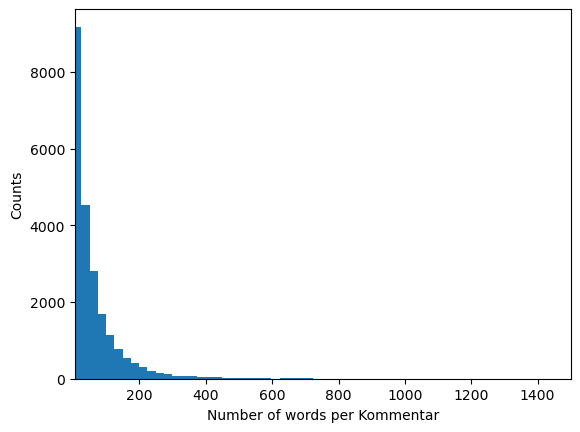

In [143]:
# Dazu zählen wir zunächst die Anzahl der Wörter in jedem Kommentare
lengths = [len(x) for x in X_train]
plt.hist(lengths, bins=100)
plt.xlim(right=1500)  #die x werte beeinflussen
plt.xlim(left=5)
# plt.ylim(bottom=100)
plt.xlabel('Number of words per Kommentar')
plt.ylabel('Counts')
plt.show()

In [144]:
max(lengths)

2491

In [145]:
min(lengths)

0

**wie man von der Histogram sehen kann haben die meisten Sätzte von bis zu 300 Wörter. Von daher stelle ich für eine max Satzlänge: max_length =300 fest**

In [146]:
max_length=300

## Pad_Sequences
Füllt Sequenzen auf die gleiche Länge nämlich auf max_length=300 auf. Die Listen werden direkt in ein NumPy-Array umgewandelt.

In [147]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     maxlen=max_length, padding='pre')
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    maxlen=max_length, padding='pre') #truncating='post'

In [148]:
print('Shapes von X_train und X_test:', X_train.shape, X_test.shape)

Shapes von X_train und X_test: (22381, 300) (5596, 300)


In [149]:
y_test.shape
y_train.shape

(22381,)

## Kalibrierung: 
Kalibrierung in Deep Learning bezieht sich auf den Prozess, den Schätzungen von Klassifikationsmodellen eine zusätzliche Bedeutung zu geben, indem sie mit den tatsächlichen Wahrscheinlichkeiten der Klassen verbunden werden. In der Praxis gibt es oft Unsicherheit in den Schätzungen von Modellen und die Kalibrierung versucht, diese Unsicherheit zu reduzieren.Kalibrierung ist ein wichtiger Schritt in der Modellbewertung und -auswahl, insbesondere für sicherheitskritische Anwendungen, wo es wichtig ist, dass die Schätzungen des Modells mit den tatsächlichen Wahrscheinlichkeiten übereinstimmen.

### Daten aufbereiten
Für die Kalibrierung des Modells legen wir zusätzlich 1000(500 von positive bzw. negative)
Kommentare beiseite und entfernen diese aus den Testdaten.

In [150]:
X_test.shape

(5596, 300)

In [247]:
num_calib = 500                                                      #~15% der Testdaten für die Kalibrierung
calib_pos_indices = np.random.choice(
    (np.argwhere(y_test == 0)).reshape(-1), size=num_calib, replace=False) #klarheit? +ve und -ve
calib_neg_indices = np.random.choice(
    (np.argwhere(y_test == 1)).reshape(-1), size=num_calib, replace=False)
y_calib = np.concatenate(
    (y_test[calib_pos_indices], y_test[calib_neg_indices]), axis=0)
X_calib = np.concatenate(
    (X_test[calib_pos_indices], X_test[calib_neg_indices]), axis=0)

X_test = np.delete(X_test, np.concatenate(
    (calib_pos_indices,calib_neg_indices)), axis=0)
y_test = np.delete(y_test, np.concatenate(
    (calib_pos_indices,calib_neg_indices)), axis=0)

In [152]:
print('Shapes von calib_pos_indices und calib_neg_ind:', calib_pos_indices.shape, calib_neg_indices.shape)
print('Shapes von X_calib und y_calib:', X_calib.shape, y_calib.shape)
print('Shapes von X_test und y_test:', X_test.shape, y_test.shape) #neue X_test und y_test 

Shapes von calib_pos_indices und calib_neg_ind: (500,) (500,)
Shapes von X_calib und y_calib: (1000, 300) (1000,)
Shapes von X_test und y_test: (4596, 300) (4596,)


In [153]:
# Zählen wie viele Datenpunkte es noch pro Klasse gibt
len_pos = len(y_train[y_train == 0])
len_neg = len(y_train[y_train == 1])
print('Number of positive tweets:', len_pos)
print('Number of negative tweets:', len_neg)

Number of positive tweets: 11295
Number of negative tweets: 11086


In [154]:
# Anzahl der Wörter aus dem Tokenizer + 1 für die Nullen aus dem Padding
num_words = num_words + 1
num_words= 5000 + 1
num_words #wird input für das Model

5001

## Modell erstellen und fitten
Ich werde ein Sequential-Model in Keras erstellen.Die erste Schicht wandelt durch ein Embedding die Wörter (Integer) in Wort-Vektoren um.
Die Nullen des Paddings können maskiert werden und werden dadurch in der folgenden LSTM-Schicht ignoriert. Sie werden beim Abarbeiten der Zeitreihe einfach ausgelassen.Die LSTM-Schichten analysieren die Reihenfolge und Zusammenhänge der Wörter
Durch return_sequences=False wird jede Sequenz auf einen einzelnen Wert reduziert.Anschließend werden diese Werte noch durch zwei Dense-Schichten analysiert Es wird eine einzelne Zahl ausgegeben, welche durch die Sigmoid-Aktivierung
zwischen 0 und 1 liegt. 1 für negative Kommentare und 0 für positive Kommentare.

In [155]:
# Die Dimensionen der Wort-Vektoren in der Embedding-schicht definieren
word_vector_length = 3  #wird frei festgestellt

In [156]:
model = keras.Sequential() #erste Schicht bekommt input_shape argument.
model.add(keras.layers.Embedding(num_words,word_vector_length,  # num_words ist Anzahl der häufigsten unique wörter bzw.neuronen
                                 input_length=max_length,mask_zero=True))  #params für die erste schicht 5000*3
model.add(keras.layers.LSTM(50, return_sequences=True, dropout=0.2, #wird output shape wird None, 300,50. 50 wegen units,200=max_leng
                            recurrent_dropout=0.2))
model.add(keras.layers.LSTM(50, return_sequences=False, dropout=0.2, #von diesen schicht werde ich wieder 50 neuron als output haben. d.h sie werden als input für die nächste Denseschicht.
                            recurrent_dropout=0.2))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Eigenschaften des neuronalen Netzes für die Optimierung festlegen
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 3)            15003     
                                                                 
 lstm_2 (LSTM)               (None, 300, 50)           10800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 48,604
Trainable params: 48,604
Non-trainable params: 0
_________________________________________________________________


In [157]:
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), 
                  batch_size=100,verbose=1)

Epoch 1/10
224/224 [==============================] - 221s 963ms/step - loss: 0.4044 - accuracy: 0.8200 - val_loss: 0.2445 - val_accuracy: 0.9062
Epoch 2/10
224/224 [==============================] - 215s 959ms/step - loss: 0.2231 - accuracy: 0.9154 - val_loss: 0.2244 - val_accuracy: 0.9175
Epoch 3/10
224/224 [==============================] - 219s 979ms/step - loss: 0.1866 - accuracy: 0.9290 - val_loss: 0.2105 - val_accuracy: 0.9195
Epoch 4/10
224/224 [==============================] - 218s 974ms/step - loss: 0.1668 - accuracy: 0.9365 - val_loss: 0.2145 - val_accuracy: 0.9204
Epoch 5/10
224/224 [==============================] - 216s 965ms/step - loss: 0.1584 - accuracy: 0.9413 - val_loss: 0.2201 - val_accuracy: 0.9193
Epoch 6/10
224/224 [==============================] - 220s 984ms/step - loss: 0.1528 - accuracy: 0.9429 - val_loss: 0.2380 - val_accuracy: 0.9138
Epoch 7/10
224/224 [==============================] - 221s 986ms/step - loss: 0.1480 - accuracy: 0.9449 - val_loss: 0.2370 -

## Model Evaluation

da ich ein Klassifikationsmodell habe, habe ich für die Bewertung des Models die übliche Metriken: **Accuracy- und Fehlerrate** verwendt. Genauigkeit:misst, wie oft das Modell die richtige Vorhersage trifft, im Verhältnis zu der Gesamtzahl der Vorhersagen.Fehlerrate(error rate): Das Gegenteil von Genauigkeit, es misst die Häufigkeit, mit der das Modell die falsche Vorhersage trifft.

In [40]:
# history= model.history
# Epoche 8 sieht gut aus

In [41]:
#LSTM
#Epoch 5/5
#loss: 0.1282 - accuracy: 0.9546 - val_loss: 0.2343 - val_accuracy: 0.9118

In [42]:
#SimpleRNN
#Epoch 5/5
#224/224 - 53s 236ms/step - loss: 0.6318 - accuracy: 0.6564 - val_loss: 0.6191 - val_accuracy: 0.6727

**Zwieschen Fazit:** 

Auswahl der Recurrent Schichten spielt eine größe Rolle. In 5 Epochen hat das model mit LSTM Val_accuracy von 91% geschafft, während mit SimpleRNN nur 67% schaffte.SimpleRNN und LSTM sind beide Arten von Recurrent Neural Networks (RNNs), die verwendet werden, um mit sequentiellen Daten wie Text oder Zeitreihen zu arbeiten. Der Unterschied besteht darin, wie sie die Informationen über die Zeit behalten. SimpleRNN hat Schwierigkeiten, langfristige Abhängigkeiten(in diesem Fall haben wir 300 Wörter) zu behalten, da es nur einen einfachen Feedforward-Mechanismus hat, um die Informationen zu speichern. Im Gegensatz dazu verwendet LSTM einen "memory cell" und spezielle "input", "forget" und "output" Gates, um die Informationen über die Zeit zu speichern und zu regulieren, was es besser dazu befähigt, langfristige Abhängigkeiten zu behalten.

In [158]:
# model.save('mental_health_model.h5')

In [159]:
from keras.models import load_model
model = load_model(r'C:\Users\alfa\Desktop\Michael\Deep Learning\woche_4\projekt arbeit\mental_health_model.h5')

### die Entwicklung von Loss , Accuracy und Val_acc über die Epochen hinweg mit Hilfe von Matplotlib grafisch darstellen.

In [160]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 224}

In [161]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [240]:
?plt.plot

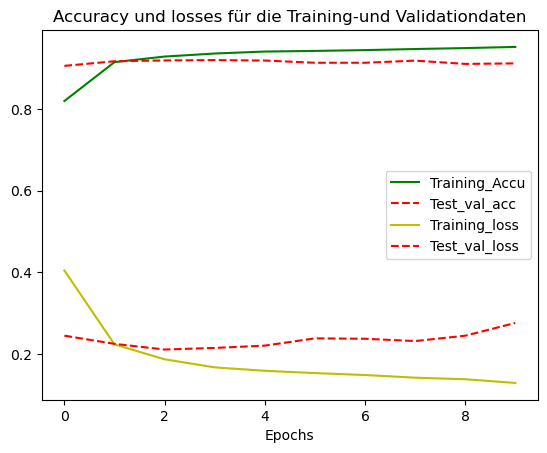

In [182]:
plt.plot(history.history['accuracy'], 'g' ,
          label='Training_Accu')
plt.plot(history.history['val_accuracy'],
         'r--', label='Test_val_acc')
plt.plot(history.history['loss'], 'y',
          label='Training_loss')
plt.plot(history.history['val_loss'],
         'r--', label='Test_val_loss')
plt.xlabel('Epochs', loc='center')
plt.title('Accuracy und losses für die Training-und Validationdaten')
plt.legend()
plt.show()

### Embedding als 3D-Plot visualisieren

Embedding ermöglicht es, kategoriale Variablen durch Vektoren von kleineren Dimensionen darzustellen, die in einen numerischen Vektorraum eingebettet sind. Dies ermöglicht es dem Modell, ähnliche kategoriale Werte in ähnlichen Vektoren zu repräsentieren und so eine bessere Leistung bei Aufgaben wie Klassifizierung oder Regression zu erzielen.

In [183]:
model.layers
model.layers[0].weights[0] #Params der erste embeding schicht

<tf.Variable 'embedding_1/embeddings:0' shape=(5001, 3) dtype=float32, numpy=
array([[ 0.03369499,  0.01689884,  0.01549002],
       [ 0.00921391, -0.00283631,  0.00487134],
       [-0.03790823, -0.02149635, -0.01131101],
       ...,
       [-0.00672817, -0.06347913, -0.02548843],
       [ 0.02465663, -0.02776539,  0.00914372],
       [ 0.0258492 , -0.03746257, -0.04357092]], dtype=float32)>

4/4 [==============================] - 0s 3ms/step


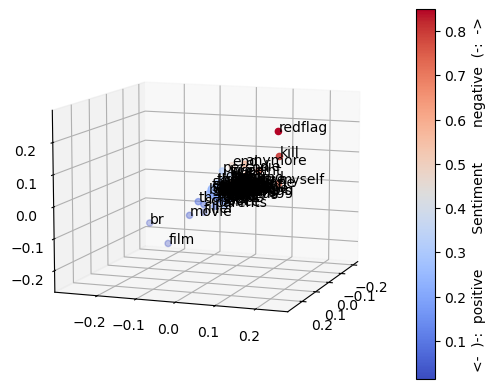

In [185]:
# Die ersten 100 häufigsten Wörter abbilden
n = 100
X_embed = model.layers[0](np.arange(n+1)) #von den 1001 werden nur 100 ausgewählt
y_embed = model.predict(np.arange(n+1).reshape(-1, 1))


# 1. Dimension der Wort-Vektoren auf der X-Achse,
# 2. Dimension auf der y-Achse, 3. Dimension auf der Z-Achse abbilden
ax = plt.figure().add_subplot(projection='3d')

ax.view_init(10, 20)
ax.scatter3D(X_embed[:, 0], X_embed[:, 1],
             X_embed[:, 2], c=y_embed, cmap='coolwarm')
for i in range(100):
    ax.text(X_embed[i+1, 0], X_embed[i+1, 1], X_embed[i+1, 2],
            list(tokenizer.word_index.keys())[i])
PCM = ax.get_children()[0]
cbar = plt.colorbar(PCM, ax=ax)

cbar.set_label('<-  )-:  positive        Sentiment        negative  (-:  ->',
               color=[0, 0, 0])
plt.show()

### Confusion-Matrix darstellen
Konfusionsmatrix berechnen, um die Genauigkeit der Klassifizierung detailiert zu bewerten.D.h um zu bewerten ob positive und negative Kommentare gleich gut prognostiziert werden und zu bewerten wie oft das model Korrekt und Falsch ist.

In [187]:
X_test.shape

(4596, 300)

In [188]:
#zunächst werde ich das Model auf den Test daten anwenden und diesen auf Ganzzahlen runden(klasse 1 und 0).
y_pred = model.predict(X_test)
y_pred = np.round(y_pred, 0)

144/144 [==============================] - 9s 60ms/step


In [195]:
y_pred.shape
# type(y_pred)

(4596, 1)

In [194]:
y_test.shape
# type(y_test)

(4596,)

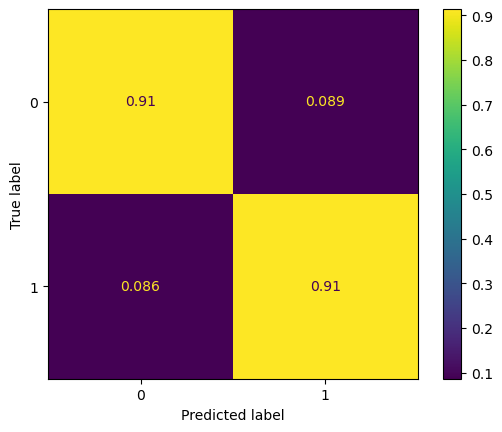

In [196]:
#Dann confusion_matrix instanz erstellen
cm = confusion_matrix(y_test, y_pred, normalize='true')    #Test daten
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
# Sehr Schlecht! Das model wieder nur mit 8 epochen fitten: Beide -ve und +ve haben schlechte Acc. und naturlich die 
#kalibrierung 

In [236]:
TP=0.91
TN=0.91
FP=0.089
FN=0.086
Genauigkeit=(TP + TN)/(TP+TN+FP+FN)
Fehlerrate=(FP + FN) / (TP + TN + FP + FN)
print('Genauigkeit:', Genauigkeit)
print('Fehlerrate:', Fehlerrate)

Genauigkeit: 0.9122807017543859
Fehlerrate: 0.08771929824561403


**Zwieschen Fazit:** 

das Model hat 91% einsen und nullen korrekt vorhergesagt(im Verhältnis zu der Gesamtzahl der Vorhersage) d.h 91 mal von 100 sagt das Model korrekt vor, während 8,7% einsen und nullen Falsch vorhergesagte.
    FN und FP sind auch ungefähr gleich.

In [237]:
X_calib.shape
y_calib

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Probability Calibration

32/32 [==============================] - 2s 75ms/step


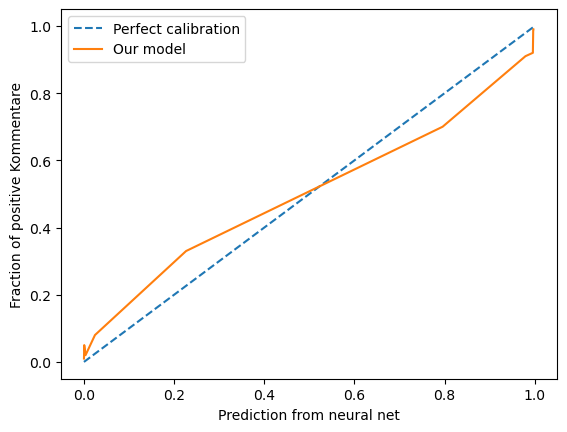

In [248]:
#Calibration Curve (reliability diagrams)
y_pred = model.predict(X_calib)
n_bins = 10
y_means, proba_means = calibration_curve(                       #y_means=prob_true und prob_pred=proba_means
    y_calib, y_pred, n_bins=n_bins, strategy='quantile') #qua

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Our model')#y_means=prob_true und proba_means=prob_pred(predicted probabilities)
plt.xlabel('Prediction from neural net') 
plt.ylabel('Fraction of positive Kommentare')                      #Fraction of -ve Kommentare?
plt.legend()
plt.show()

---------------Calibration---------------
Prediction of x_calib before calibration 0.0060236785
Prediction of x_calib before calibration 0.040475916813260515


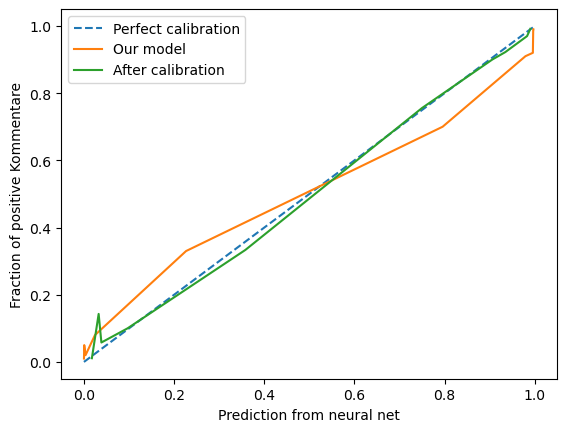

In [249]:
#post_prozessing
# Als Kalibrierungsmodell wird gerne eine isotonische Regression verwendet,
# diese erstellt eine Ausgleichskurve welche monoton steigt
ir = IsotonicRegression()
ir.fit(proba_means.reshape(-1, 1), y_means)
print('-'*15+'Calibration'+'-'*15)
print('Prediction of x_calib before calibration', y_pred[0, 0])

y_pred_calib = ir.transform(y_pred)
print('Prediction of x_calib before calibration', y_pred_calib[0]) 

y_calib=y_calib[y_pred_calib>0]
# y_calib=y_calib[y_pred_calib==y_pred_calib]
y_pred_calib=y_pred_calib[y_pred_calib>0]
# y_pred_calib=y_pred_calib[y_pred_calib==y_pred_calib]

y_means_calib, proba_means_calib = calibration_curve(
    y_calib, y_pred_calib, n_bins=n_bins, strategy='quantile')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect calibration')
plt.plot(proba_means, y_means, label='Our model')
plt.plot(proba_means_calib, y_means_calib, label='After calibration')
plt.xlabel('Prediction from neural net')
plt.ylabel('Fraction of positive Kommentare')              
plt.legend()
plt.show()

In [ ]:
#Eigenes Beispiel beurteilen

In [268]:
# example=["hey hurry hurry the time is going. please don't waste any more time!"]
example=["I Hope you like it!"]

In [266]:
# Tokenizing
encoded_docs = tokenizer.texts_to_sequences(example)

# Padding
padded_docs = keras.preprocessing.sequence.pad_sequences(encoded_docs,
                                                         maxlen=max_length, padding='pre')
print('Tokenized and padded sequence:', padded_docs)


# Benutzung der Sentiment-Analyse
result = model.predict(padded_docs)
print('Prediction before calibration:', result[0, 0])

# Das Ergebnis durch die Kalibrierung nochmal leicht anpassen
result = ir.transform(result)

print('Prediction after calibration:', result[0])
print()
if result[0] < 0.5:  # 1 negative, 0 positive
    print('Kommentar is rather positive')
else:
    print('Kommentar is rather negative')

Tokenized and padded sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  